In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [23]:
path = "laion_scores_full_experiment_preliminary_results.json"


with open(path, "r") as f:
    data = json.load(f)

cosine: n=335, mean=4.1227, std=0.3605, min=3.0938, 25%=3.8906, median=4.1250, 75%=4.3750, max=5.2812, p5=3.5000, p95=4.6875, IQR=0.4844
pearson: n=335, mean=4.1703, std=0.3544, min=3.1094, 25%=3.9375, median=4.1875, 75%=4.4062, max=5.1562, p5=3.5000, p95=4.7188, IQR=0.4688
rmse: n=335, mean=4.1474, std=0.3564, min=2.8906, 25%=3.9219, median=4.1562, 75%=4.4062, max=4.9375, p5=3.5484, p95=4.7188, IQR=0.4844


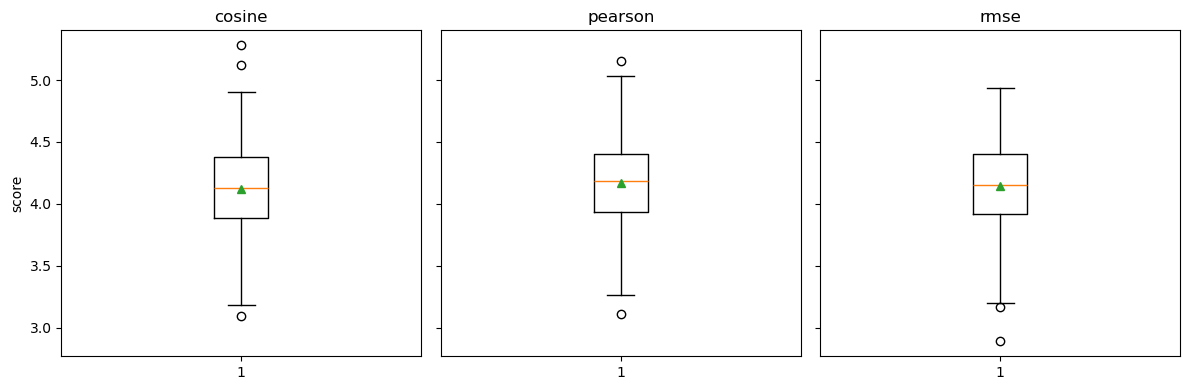

In [24]:
cosine_scores = [item['cosine'] for item in data.values()]
rmse_scores = [item['rmse'] for item in data.values()]
prs_scores = [item['pearson'] for item in data.values()]

# use your lists
cos = np.asarray(cosine_scores, dtype=float)
prs = np.asarray(prs_scores, dtype=float)
rmse = np.asarray(rmse_scores, dtype=float)

def describe(name, x):
    x = x[np.isfinite(x)]
    q5, q25, q50, q75, q95 = np.percentile(x, [5, 25, 50, 75, 95])
    iqr = q75 - q25
    print(f"{name}: n={x.size}, mean={x.mean():.4f}, std={x.std(ddof=1):.4f}, "
          f"min={x.min():.4f}, 25%={q25:.4f}, median={q50:.4f}, 75%={q75:.4f}, "
          f"max={x.max():.4f}, p5={q5:.4f}, p95={q95:.4f}, IQR={iqr:.4f}")

for name, arr in [("cosine", cos), ("pearson", prs), ("rmse", rmse)]:
    describe(name, arr)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, (name, arr) in zip(axs, [("cosine", cos), ("pearson", prs), ("rmse", rmse)]):
    ax.boxplot(arr, vert=True, showmeans=True)
    ax.set_title(name)
axs[0].set_ylabel("score")
plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import wilcoxon, rankdata
from itertools import combinations

methods = [cosine_scores, prs_scores, rmse_scores]
labels  = ['Cosine', 'Pearson', 'RMSE']

items = list(zip(labels, methods))

results = []
for (label1, m1), (label2, m2) in combinations(items, 2):
    stat, p = wilcoxon(m1, m2)
    d = np.asarray(m1) - np.asarray(m2)
    d = d[d != 0] 
    ranks = rankdata(np.abs(d), method='average')
    Wp = ranks[d > 0].sum()
    Wm = ranks[d < 0].sum()
    r_rb = (Wp - Wm) / ranks.sum()

    results.append((label1, label2, stat, p, r_rb))

print("Mean ± SD per metodo:")
for label, m in zip(labels, methods):
    mean = np.mean(m)
    sd   = np.std(m, ddof=1)
    print(f"  {label}: {mean:.3f} ± {sd:.3f}")
print()

print("Statistical Test Results:")
for (label1, label2, stat, p, r_rb) in results:
    print(f"Comparison between {label1} and {label2}:")
    print(f"  Statistic: {stat}, p-value: {p}, r_rank-biserial: {r_rb:.3f}")
    if p < 0.05:
        print("  Significant difference detected.")
    else:
        print("  No significant difference detected.")
    print()


Mean ± SD per metodo:
  Cosine: 4.123 ± 0.361
  Pearson: 4.170 ± 0.354
  RMSE: 4.147 ± 0.356

Statistical Test Results:
Comparison between Cosine and Pearson:
  Statistic: 14770.0, p-value: 1.1830722241359065e-08, r_rank-biserial: -0.375
  Significant difference detected.

Comparison between Cosine and RMSE:
  Statistic: 22854.5, p-value: 0.039632177715186304, r_rank-biserial: -0.132
  Significant difference detected.

Comparison between Pearson and RMSE:
  Statistic: 23704.5, p-value: 0.1202660517495873, r_rank-biserial: 0.100
  No significant difference detected.

